In [1]:
%matplotlib inline
import numpy as np
import sklearn.cluster
import sklearn.feature_extraction
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import itertools

###Fake Testing

In [2]:
# Generate a random data matrix. n = number of data points; m = length of each data point; num_types = number of types
def gen_data(n, m, num_types):
    # type for each data point (each from 0 to n-1)
    types = np.trunc(np.random.random_sample(n)*num_types)
    # list of random vectors of m integers between 20 and 40, to serve as the mean for each type
    means = [np.random.randint(20,40,m) for t in range(num_types)]
    # list of vectors of standard deviations for each type
    stddevs = 2 * np.ones([num_types,m])
    # generate a data matrix and round to the nearest thousandth
    return np.round(map(lambda t : list(np.random.randn(len(means[t])) * stddevs[t] + means[t]), map(int, types)),3)

In [3]:
# run k-means clustering on M, for each k values in k_vals
def k_mean_test(M, k_vals):
    results = []
    # sum of squared Euclidean distances from mean
    var = sum(np.var(M,0))*len(M)
    # loop through all k values provided
    for k in k_vals:
        # fit k-means clusterer
        fit = sklearn.cluster.KMeans(n_clusters=k).fit(M)
        # sum of squared Euclidean distance from cluster center
        within_var = sum(map(lambda r : min(r)**2, fit.transform(M)))
        results.append((fit, k, within_var/var))
    return results

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0.99999999999999789, 0.32180735035231189, 0.22184753936708182, 0.12823005165355578, 0.10790842602421241, 0.10052724510247388, 0.094423861859703362, 0.089569673420604817, 0.084372002818723257, 0.080268705645093683]]
Wall time: 435 ms


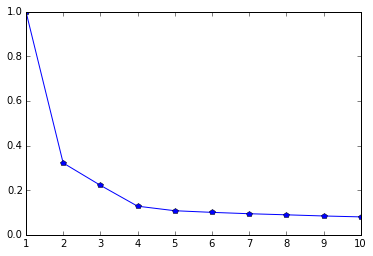

In [4]:
%%time
# generate 200 data points in R^4, with 5 topics
M = gen_data(200, 4, 5)
# plot results for k=1 to 10
results = k_mean_test(M, range(1,11))
plot_results = map(list, zip(*[(b,c) for a,b,c in results]))
print plot_results
plt.plot(plot_results[0], plot_results[1], 'p-')

###Fitting Model with Training Data

In [5]:
%%time
# read in data from csv
noun_train_mat = np.loadtxt("noun_train_mat.csv", delimiter = ",")
# use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(noun_train_mat)
noun_train_mat = tf_idf_fit.transform(noun_train_mat).toarray()

Wall time: 40.3 s


In [6]:
%%time
kmeans_fit = sklearn.cluster.KMeans(n_clusters=14).fit(noun_train_mat)
# compute the ratio of within-group sum of squared distances to cluster mean to total sum of squared distances to overall mean
ssq = sum(np.var(noun_train_mat,0))*len(noun_train_mat)
within_ssq = sum(map(lambda r : min(r)**2, kmeans_fit.transform(noun_train_mat)))
print within_var / var
#results.append((k, within_var/var))

#plot_results = map(list, zip(*k_mean_test(M, range(1,21))))
#print plot_results
#plt.plot(plot_results[0], plot_results[1], 'p-')

Wall time: 33.6 s


In [7]:
%%time
# use the fit above to cluster the data
clusters = kmeans_fit.predict(noun_train_mat)
cluster_lists = [[i for i,j in enumerate(clusters) if j==cluster] for cluster in range(14)]
print 'Number of documents per cluster:', [len(clusters[clusters==i]) for i in range(14)]
# uncomment this loop to see a list of documents by cluster
#for cluster in range(14):
#    print
#    print 'Documents in category %s:' % cluster, cluster_lists[cluster]

Number of documents per cluster: [36, 97, 51, 157, 96, 96, 66, 27, 68, 78, 27, 24, 269, 18]
Wall time: 113 ms


###Comparing with Supreme Court Database's Topic Areas

In [8]:
# read in SC Database's issue areas from csv
noun_train_issue_areas = np.loadtxt("noun_train_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
noun_train_issue_areas = noun_train_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in noun_train_issue_areas]) for i in range(14)]

Number of documents per category: [238, 188, 96, 36, 10, 8, 64, 242, 131, 56, 10, 30, 1, 0]


In [9]:
# create a 14x14 matrix (where each row is a k-means cluster and each column is an SCDB cluster) measuring the degree of
# related-ness between each cluster pair
compare_mat = map(lambda r : map(int, r), np.zeros((14,14)))
# first, assign the (i,j) element in the matrix to the number of cases in k-means cluster i and SCDB cluster j, for each (i,j)
for i,j in zip(clusters, noun_train_issue_areas):
    compare_mat[i][j] += 1
# normalize each row to have a sum of 1
compare_mat = map(lambda row : map(float,row) / sum(row), np.array(compare_mat))

### commented out because I realized this method of assignment does the same thing as the one-line assignment below
#assignments = -1 * np.ones(14)
#compare_mat_flat = [x for lst in compare_mat for x in lst]
#while min(assignments) == -1:
#    max_ind = np.argmax(compare_mat_flat)
#    row = max_ind / 14
#    if assignments[row] == -1:
#        column = max_ind - 14 * row
#        assignments[row] = column
#    else:
#        compare_mat_flat[max_ind] = -1
#assignments = map(int, assignments)
#print assignments

# assign each k-means cluster to a (not necessarily unique) SCDB cluster by picking the highest element of each row of compare_mat
assignments = map(np.argmax, compare_mat)
print assignments
# this would be the equivalent way of assigning each SCDB cluster to an k-means cluster; this is printed here but not used anywhere
print map(np.argmax, np.array(compare_mat).T)

[1, 1, 0, 8, 0, 0, 7, 7, 6, 7, 7, 1, 7, 10]
[1, 1, 0, 8, 0, 0, 7, 7, 6, 7, 7, 1, 7, 10]
[2, 11, 0, 11, 1, 1, 8, 7, 3, 13, 13, 6, 10, 0]
[[ 0.02777778  0.52777778  0.33333333  0.02777778  0.02777778  0.          0.
   0.          0.02777778  0.          0.          0.02777778  0.          0.        ]
 [ 0.1443299   0.35051546  0.1443299   0.04123711  0.04123711  0.02061856
   0.          0.13402062  0.11340206  0.01030928  0.          0.          0.
   0.        ]
 [ 0.92156863  0.03921569  0.          0.03921569  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.07006369  0.22929936  0.05095541  0.01910828  0.00636943  0.
   0.00636943  0.17834395  0.41401274  0.02547771  0.          0.          0.
   0.        ]
 [ 0.77083333  0.10416667  0.04166667  0.01041667  0.          0.          0.
   0.04166667  0.03125     0.          0.          0.          0.          0.        ]
 [ 0.60416667  0.14583333  0.02083333  0.06

In [10]:
# use the assignments above to convert the clusters into equivalent SCDB categories for each document
new_clusters = map(lambda cluster : assignments[cluster], clusters)
# compute and output accuracy rate
correct = map(lambda (c1,c2) : c1==c2, zip(new_clusters, noun_train_issue_areas))
print float(sum(correct)) / len(correct)

0.501801801802


###Use Rand Index to Compute Accuracy on Training Data

Each pair of documents is called a true positive ($tp$) if the two documents end up in the same cluster correctly, a true negative ($tn$) if the documents end up in different clusters correctly, a false positive ($fp$) if the documents are placed in the same cluster but should have been in different clusters, and a false negative ($fn$) if the documents are placed in different clusters but should have been in the same cluster.

The Rand index (measuring the similarity between the k-means clustering and the SCDB categories) is defined as $\frac{tp+tn}{tp+tn+fp+fn}$.

In [11]:
%%time
if 'cluster_pairs_model' in globals():
    del cluster_pairs_model
if 'cluster_pairs_actual' in globals():
    del cluster_pairs_actual

# use itertools to create pairs of documents, using the k-means clusters and SCDB categories
cluster_pairs_model = itertools.product(clusters, clusters)
cluster_pairs_actual = itertools.product(noun_train_issue_areas, noun_train_issue_areas)
# loop through all document pairs to compute tp, tn, fp, and fn
(tp,tn,fp,fn) = 0, 0, 0, 0
for pair1,pair2 in zip(cluster_pairs_model, cluster_pairs_actual):
    if (pair1[0]==pair1[1]):
        if (pair2[0]==pair2[1]):
            tp += 1
        else:
            fp += 1
    else:
        if (pair2[0]==pair2[1]):
            fn += 1
        else:
            tn += 1

# output tp, tn, fp, and fn
print tp,tn,fp,fn
# compute and output Rand index using formula from above
rand_index_train = float(tp+tn)/(tp+tn+fp+fn)
print rand_index_train

39958 939266 106212 146664
0.794760165571
Wall time: 2.07 s


###Applying Model to Test Data

In [12]:
%%time
# read in test data from csv
noun_test_mat = np.loadtxt("noun_test_mat.csv", delimiter = ",")
# use TF-IDF fit from training data to scale each document's vector to have norm 1 and place a lower weight on very common words
noun_test_mat = tf_idf_fit.transform(noun_test_mat).toarray()

Wall time: 16.5 s


In [13]:
%%time
# use k-means fit from training data to cluster test observations
clusters_test = kmeans_fit.predict(noun_test_mat)
cluster_lists_test = [[i for i,j in enumerate(clusters_test) if j==cluster] for cluster in range(14)]
print 'Number of documents per cluster:', [len(clusters_test[clusters_test==i]) for i in range(14)]
# uncomment this loop to see a list of documents by cluster
#for cluster in range(14):
#    print
#    print 'Documents in category %s:' % cluster, cluster_lists_test[cluster]

Number of documents per cluster: [6, 36, 10, 68, 47, 26, 29, 5, 21, 26, 10, 7, 185, 9]
Wall time: 59 ms


###Compare Test Data Results to SC Database Categories

In [14]:
# read in SC Database's issue areas from csv
noun_test_issue_areas = np.loadtxt("noun_test_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
noun_test_issue_areas = noun_test_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in noun_test_issue_areas]) for i in range(14)]

Number of documents per category: [104, 95, 26, 22, 3, 7, 18, 96, 63, 25, 5, 17, 4, 0]


In [15]:
# use the assignments above to convert the clusters into equivalent SCDB categories for each document
new_clusters_test = map(lambda cluster : assignments[cluster], clusters_test)
# compute and output accuracy rate
correct_test = map(lambda (c1,c2) : c1==c2, zip(new_clusters_test, noun_test_issue_areas))
print float(sum(correct_test)) / len(correct_test)

0.468041237113


###Use Rand Index to Compute Accuracy on Test Data

In [16]:
%%time
if 'cluster_test_pairs_model' in globals():
    del cluster_test_pairs_model
if 'cluster_test_pairs_actual' in globals():
    del cluster_test_pairs_actual

# use itertools to create pairs of documents, using the k-means clusters and SCDB categories
cluster_test_pairs_model = itertools.product(clusters_test, clusters_test)
cluster_test_pairs_actual = itertools.product(noun_test_issue_areas, noun_test_issue_areas)
# loop through all document pairs to compute tp, tn, fp, and fn
(tp,tn,fp,fn) = 0, 0, 0, 0
for pair1,pair2 in zip(cluster_test_pairs_model, cluster_test_pairs_actual):
    if (pair1[0]==pair1[1]):
        if (pair2[0]==pair2[1]):
            tp += 1
        else:
            fp += 1
    else:
        if (pair2[0]==pair2[1]):
            fn += 1
        else:
            tn += 1

# output tp, tn, fp, and fn
print tp,tn,fp,fn
# compute and output Rand index using formula from above
rand_index_test = float(tp+tn)/(tp+tn+fp+fn)
print rand_index_test

10137 164460 35242 25386
0.742255287491
Wall time: 385 ms
